In [1]:
#库函数
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  


In [2]:
from data_cleaning import process_and_merge_all

file_prefix_list = [
    ('../data/518880.SH_20250101_20250630.csv', 'ETF'),
    ('../data/AU(T+D).SGE_20250101_20250630.csv', 'TD')]

merged_df = process_and_merge_all(file_prefix_list, freq='30S', method='last')


/Users/guziyi/Desktop/htsc/gold_pairstrading/code/data_cleaning.py:29: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_agg = df_filtered.resample(freq).last()
/Users/guziyi/Desktop/htsc/gold_pairstrading/code/data_cleaning.py:29: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_agg = df_filtered.resample(freq).last()


In [3]:
import pandas as pd
from kalman_filter import kalman_and_cointegration
#from signal_updated import generate_signal_with_weighted_z

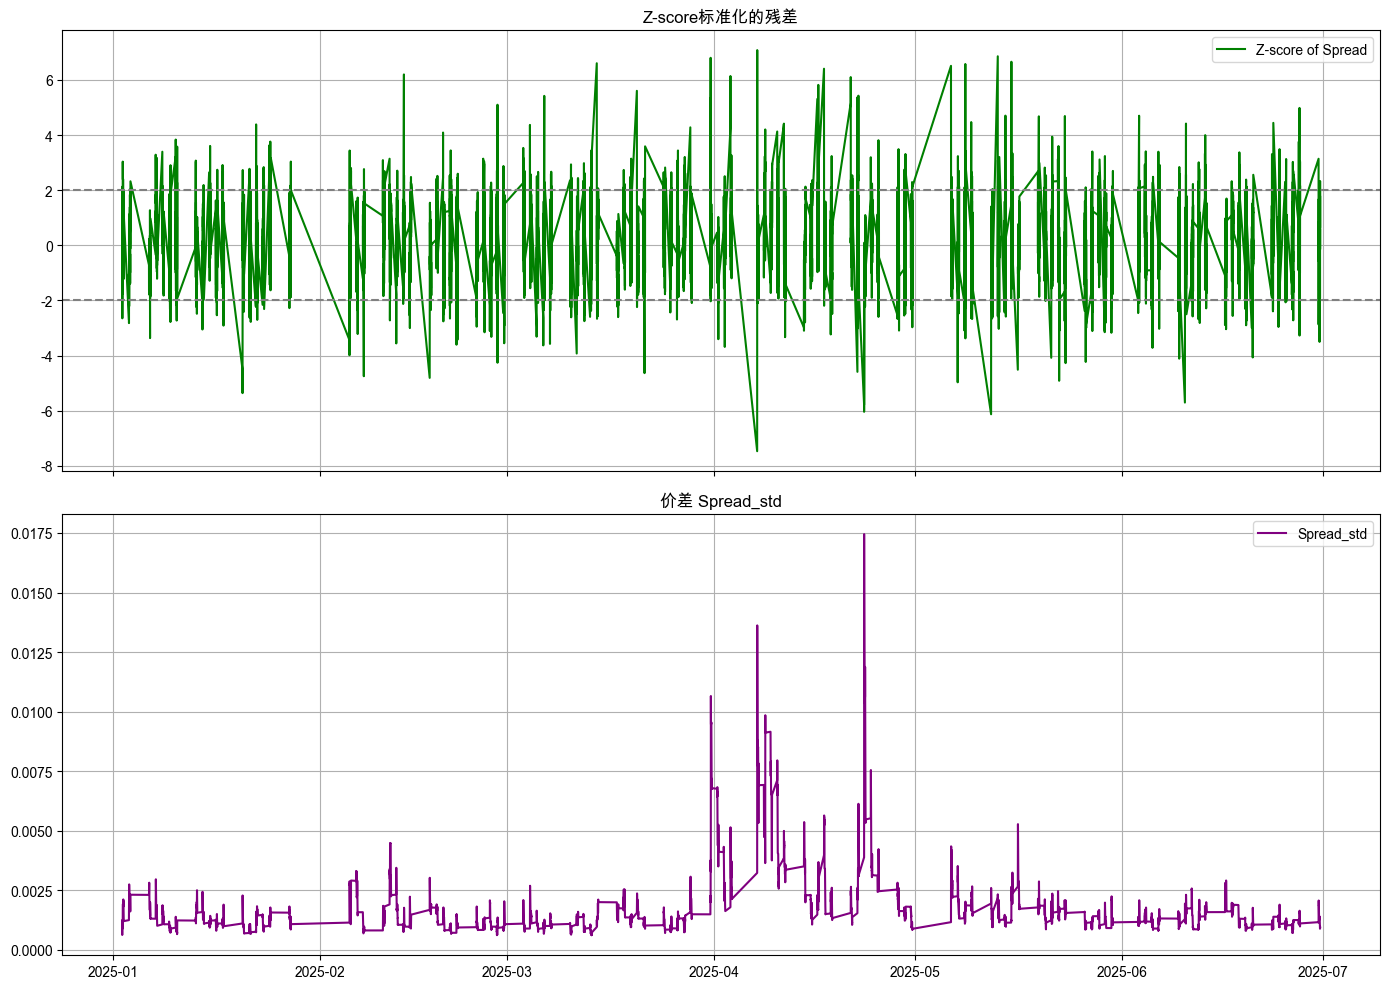

,DateTime,ETF_Price,TD_Price,beta_kalman,spread,zscore
0,2025-01-02 09:30:00,5.9775,621.680,0.009615,0.000000,NaN
1,2025-01-02 09:30:30,5.9785,621.940,0.009615,-0.001498,-0.703553
2,2025-01-02 09:31:00,5.9795,621.990,0.009615,-0.000977,-0.196154
3,2025-01-02 09:31:30,5.9795,621.990,0.009615,-0.000975,-0.176564
4,2025-01-02 09:32:00,5.9785,622.135,0.009615,-0.003364,-1.594358
...,...,...,...,...,...,...
516175,2025-06-30 14:57:30,7.3155,762.550,0.009589,0.003487,2.330991
516176,2025-06-30 14:58:00,7.3155,762.560,0.009589,0.003387,2.158277
516177,2025-06-30 14:58:30,7.3145,762.455,0.009589,0.003389,2.101241
516178,2025-06-30 14:59:00,7.3135,762.380,0.009589,0.003104,1.766245


In [4]:
kalman_and_cointegration(merged_df, win=10,early_stop=True)

#df_with_signal = generate_signal_with_weighted_z(
    #merged_df,
    #z_col='zscore',
    #beta_col='beta_kalman',
    #time_col='DateTime',
    #base_open_h=3.0,
    #base_open_l=-3.0,
    #alpha=5.0,
    #close_h=0.5,
    #close_l=-0.5,
    #stop_spread=1.5,
    #max_hold_minutes=15,
    #beta_diff_base_tol=0.01,
    #beta_diff_alpha_z=0.01,
    #z_weight_gamma=3.0,
    #start_index=None
#)

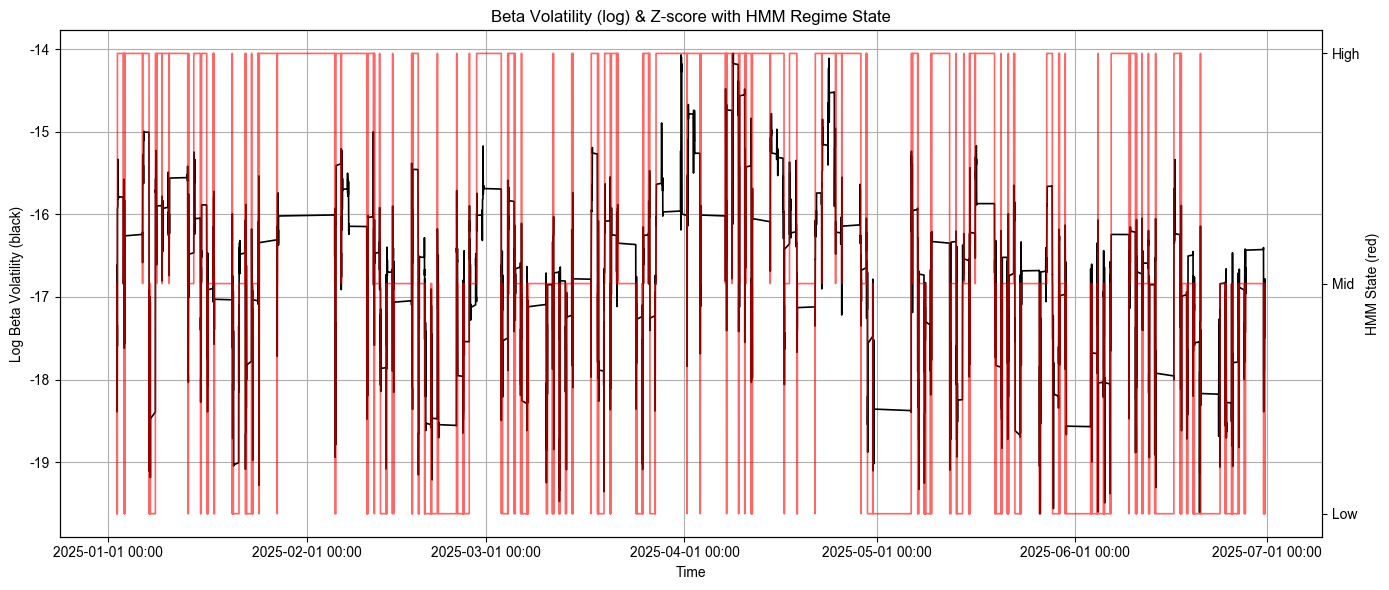

In [5]:
from HMM import train_hmm_on_beta_vol_and_plot,generate_signal_with_hmm_state

df, hmm_model = train_hmm_on_beta_vol_and_plot(merged_df,time_col='DateTime')

df = generate_signal_with_hmm_state(df)


/Users/guziyi/Desktop/htsc/gold_pairstrading/code/backtest.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['frozen_beta'] = df['frozen_beta'].fillna(method='ffill')


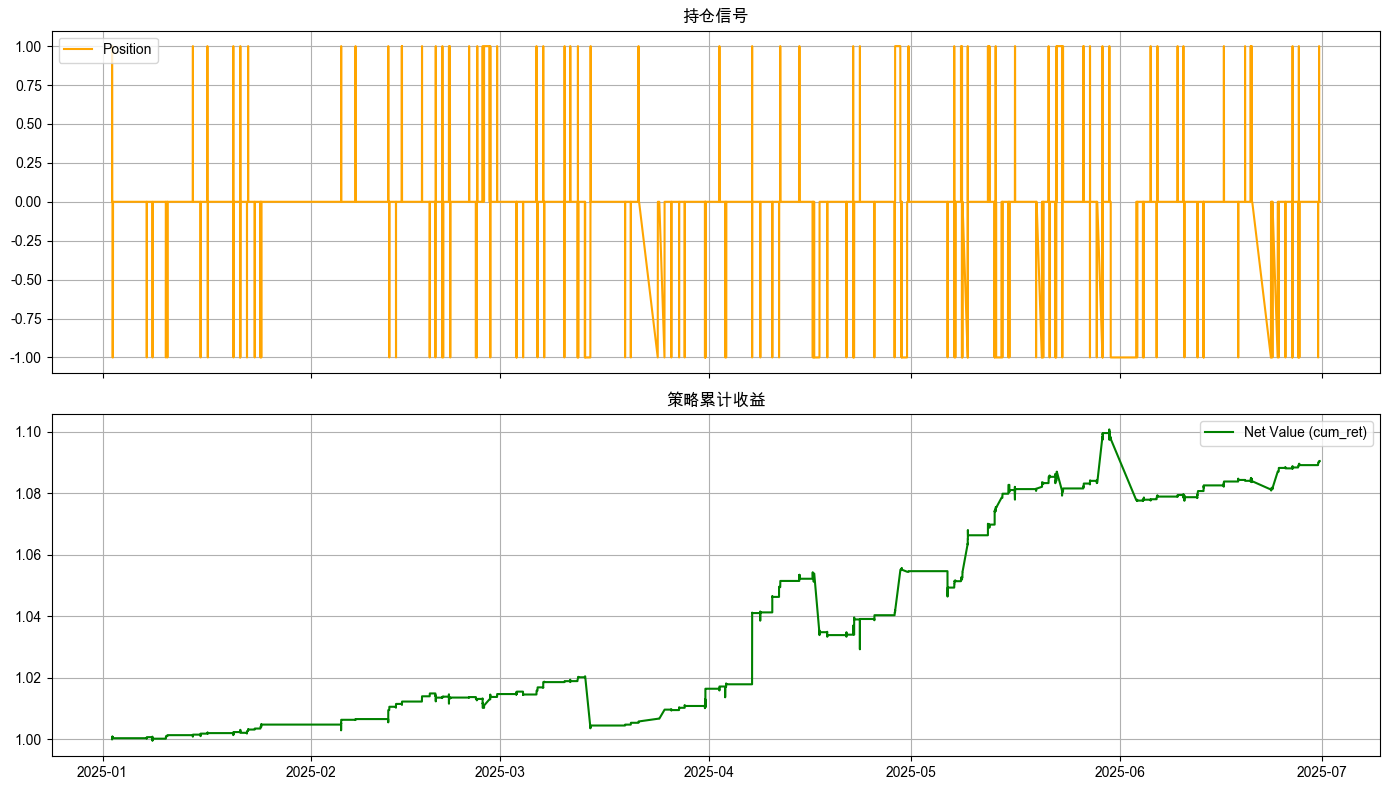

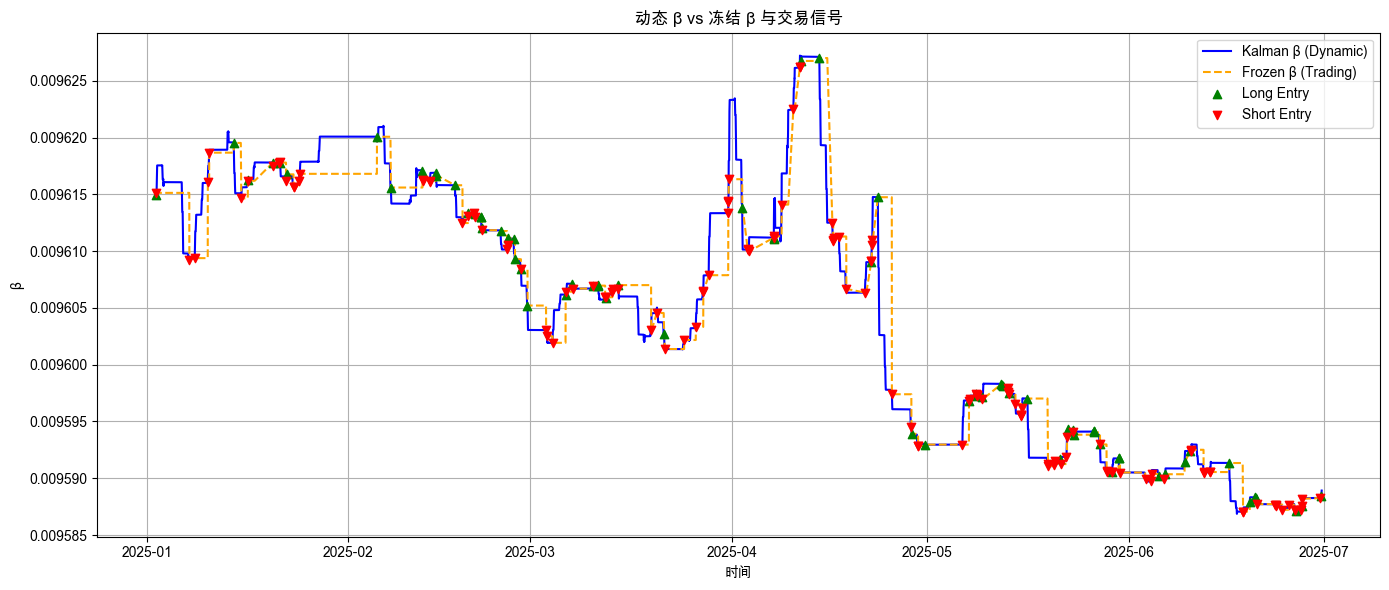

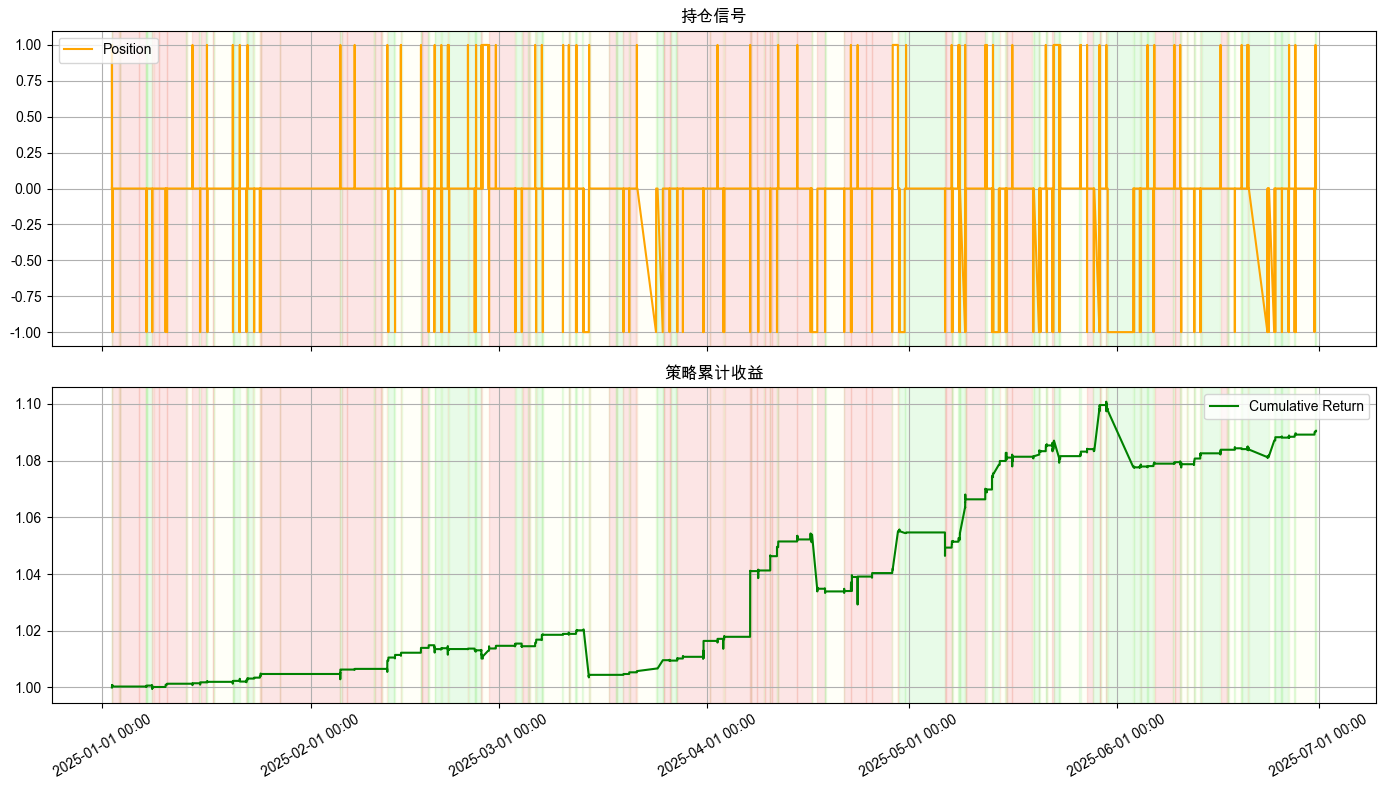

In [6]:
from backtest import calculate_pair_strategy_returns, plot_beta_vs_frozen_with_signals,plot_position_and_return_with_hmm

df_result = calculate_pair_strategy_returns(
    df,
    price_y='ETF_Price',
    price_x='TD_Price',
    beta_col='beta_kalman',
    signal_col='signal'
)

plot_beta_vs_frozen_with_signals(df_result)

plot_position_and_return_with_hmm(df_result)

In [ ]:
from hmmlearn.hmm import GaussianHMM

In [ ]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def train_hmm_on_beta_vol_and_plot(
    df,
    beta_col='beta_kalman',
    time_col='DateTime',
    window=60,
    n_states=2,
    vol_col='beta_vol',
    state_col='beta_state'
):
    """
    对 beta 的波动率进行建模 + HMM regime 拟合 + 状态可视化（强化初始状态设定）
    """
    df = df.copy()

    # Step 1：计算 beta_vol（rolling std）+ log + 标准化
    df[vol_col] = df[beta_col].rolling(window=window, min_periods=10).std()
    df[vol_col] = np.log(df[vol_col] + 1e-9)  # log 变换防止 0
    vol_data = df[vol_col].dropna()
    vol_mean = vol_data.mean()
    vol_std = vol_data.std()
    vol_scaled = ((vol_data - vol_mean) / vol_std).values.reshape(-1, 1)

    # Step 2：构建 HMM + 初始化参数（强引导）
    model = GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        init_params="stmc",  # 不再随机初始化 means, covars
        random_state=42
    )

    # 设置初始状态概率
    model.startprob_ = np.array([0.5, 0.5])
    model.transmat_ = np.array([
        [0.95, 0.05],
        [0.05, 0.95]
    ])

    # 设置初始状态均值（你可以根据图像做微调）
    model.means_ = np.array([[-1.0], [1.0]])  # 先设为标准化后的两个极端
    model.covars_ = np.tile(np.identity(1) * 1.0, (n_states, 1, 1))  # 每个状态的协方差

    # Step 3：拟合模型
    model.fit(vol_scaled)
    hidden_states = model.predict(vol_scaled)

    # Step 4：将状态按均值排序（低波动=0，高波动=1）
    means = [vol_scaled[hidden_states == i].mean() for i in range(n_states)]
    state_order = np.argsort(means)
    mapping = {original: new for new, original in enumerate(state_order)}
    mapped_states = np.array([mapping[s] for s in hidden_states])

    # Step 5：写入原始 df
    df.loc[df[vol_col].notnull(), state_col] = mapped_states

    # Step 6：画图（beta_vol + HMM 状态）
    df_plot = df.dropna(subset=[vol_col, state_col])
    times = df_plot[time_col]
    beta_vol = df_plot[vol_col]
    states = df_plot[state_col]

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # beta_vol 折线
    ax1.plot(times, beta_vol, label='Beta Volatility (log)', color='black', linewidth=1.2)
    ax1.set_ylabel('Log Beta Volatility (black)')
    ax1.set_xlabel('Time')
    ax1.grid(True)

    # beta_state 红色阶梯线
    ax2 = ax1.twinx()
    ax2.step(times, states, label='HMM State (0=Low, 1=High)', color='red', linewidth=1.2, where='post', alpha=0.6)
    ax2.set_ylabel('HMM State (red)')
    ax2.set_ylim(-0.1, 1.1)
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['Low', 'High'])

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=30)
    plt.title('Beta Volatility (log) with HMM Regime State')
    fig.tight_layout()
    plt.show()

    return df, model

In [ ]:
import matplotlib.dates as mdates

def plot_beta_vol_states(df, time_col='DateTime', vol_col='beta_vol', state_col='beta_state'):
    """
    可视化 beta 波动率 + HMM 状态（高/低波动）
    """
    df = df.copy()
    df = df.dropna(subset=[vol_col, state_col])
    
    times = df[time_col]
    beta_vol = df[vol_col]
    states = df[state_col]

    fig, ax = plt.subplots(figsize=(14, 6))

    # 1. 绘制 beta_vol 折线
    ax.plot(times, beta_vol, label='Beta Volatility', color='black', linewidth=1.2)

    # 2. 着色背景：不同状态区域染色
    unique_states = states.unique()
    colors = {0: 'lightgreen', 1: 'lightcoral'}  # 你可以自己调颜色
    current_state = states.iloc[0]
    start_idx = 0

    for i in range(1, len(states)):
        if states.iloc[i] != current_state:
            ax.axvspan(times.iloc[start_idx], times.iloc[i], 
                       color=colors.get(current_state, 'lightgrey'), alpha=0.3)
            current_state = states.iloc[i]
            start_idx = i
    # 最后一个区域
    ax.axvspan(times.iloc[start_idx], times.iloc[-1], 
               color=colors.get(current_state, 'lightgrey'), alpha=0.3)

    # 格式美化
    ax.set_title('Beta Volatility with HMM Regime States')
    ax.set_ylabel('Beta Volatility (Rolling Std)')
    ax.set_xlabel('Time')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_beta_vol_states(merged_df)

KeyError: ['beta_vol', 'beta_state']

In [ ]:
#没有封装的代码
OBS_VAR = 0.01
STATE_VAR = 0.0001
INIT_VAR = 0.1
WIN = 10
df = pd.read_excel("merged_data1.xlsx")
df['datetime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values("datetime").reset_index(drop=True)
# === 初始化Kalman状态 ===
state_var = INIT_VAR

betas = []
spreads = []

# 用循环一行行处理，确保 beta 是随着每个 tick 演化的
for i in range(len(df)):
    py = df['ETF_Price'].iloc[i]
    px = df['TD_Price'].iloc[i]
    if i == 0:
        # 初始化状态
        state_mean = py / px  # 初始 beta
    else:
        # 使用前一行的状态
        state_mean = betas[-1]
    pred_mean = state_mean
    pred_var = state_var + STATE_VAR

    k_gain = pred_var / (pred_var * px**2 + OBS_VAR)
    state_mean = pred_mean + k_gain * (py - pred_mean * px)
    state_var = (1 - k_gain * px) * pred_var

    beta = state_mean
    spread = py - beta * px

    betas.append(beta)
    spreads.append(spread)

# 保存进df中，确保时间对齐
df['beta'] = betas
df['spread'] = spreads

df['spread'] = df['ETF_Price'] - df['beta'] * df['TD_Price']
lambda_ = 0.01  # 越小越平滑
df['spread_mean'] = df['spread'].ewm(alpha=lambda_).mean()
df['spread_std'] = df['spread'].ewm(alpha=lambda_).std()
df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

In [ ]:
OPEN_H = 3.0
OPEN_L = -3.0
CLOSE_H = 0.5
CLOSE_L = -0.5
STOP_SPREAD = 3.0
MAX_HOLD = 10

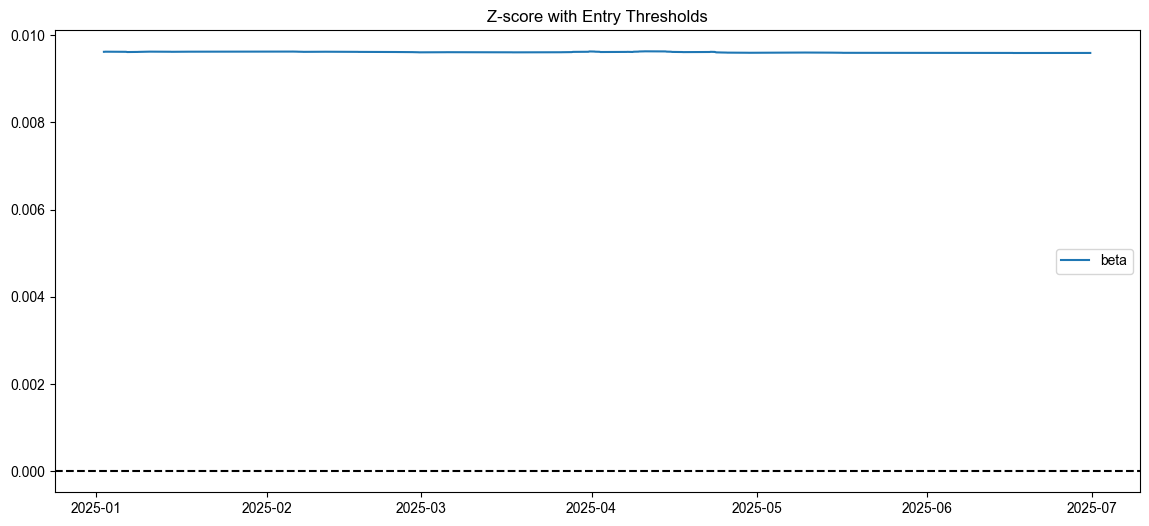

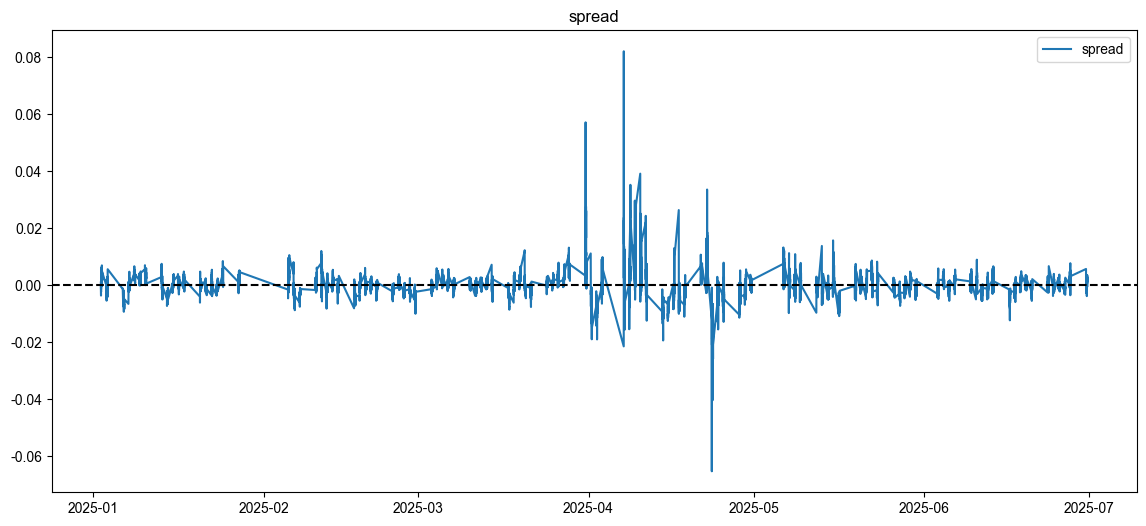

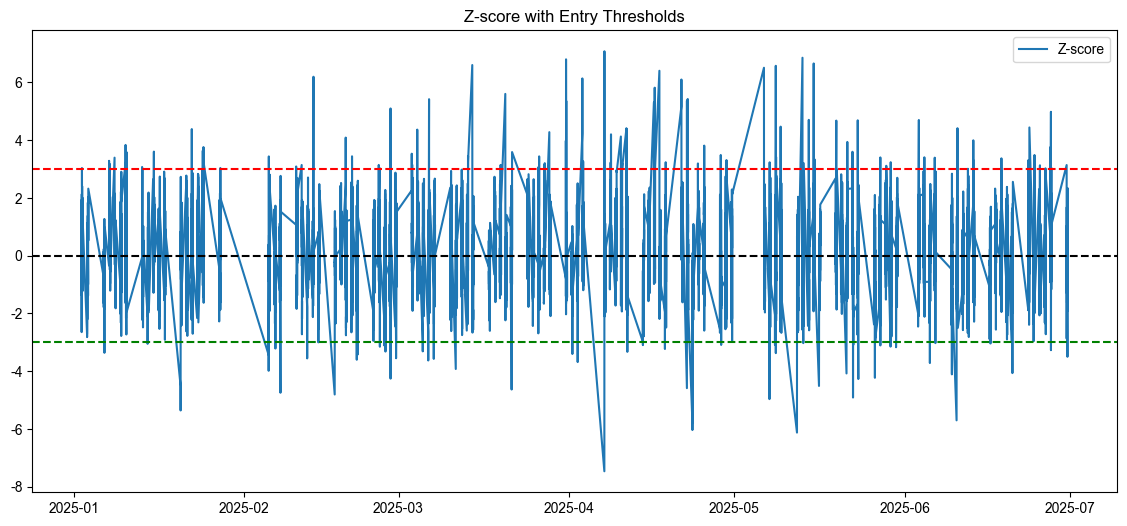

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['DateTime'], df['beta'], label='beta')
plt.axhline(0, color='black', linestyle='--')
plt.title('Z-score with Entry Thresholds')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(df['DateTime'], df['spread'], label='spread')
plt.axhline(0, color='black', linestyle='--')
plt.title('spread')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(df['DateTime'], df['zscore'], label='Z-score')
plt.axhline(OPEN_H, color='red', linestyle='--')
plt.axhline(OPEN_L, color='green', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.title('Z-score with Entry Thresholds')
plt.legend()
plt.show()

In [ ]:
# === 5. 生成交易信号 ===
df['signal'] = 0  # 1=做多，-1=做空，0=平仓或无信号
position = 0
entry_z = None
entry_time = None
hold_days = 0

for i in range(WIN, len(df)):
    z = df.loc[i, 'zscore']
    date = df.loc[i, 'datetime'].date()
    prev_date = df.loc[i - 1, 'datetime'].date()
    
    if position != 0 and date != prev_date:
        hold_days += 1

    if position == 0:
        if z < OPEN_L:
            df.loc[i, 'signal'] = 1
            position = 1
            entry_z = z
            entry_time = df.loc[i, 'datetime']
            hold_days = 0
        elif z > OPEN_H:
            df.loc[i, 'signal'] = -1
            position = -1
            entry_z = z
            entry_time = df.loc[i, 'datetime']
            hold_days = 0
    else:
        profit_cond = CLOSE_L < z < CLOSE_H
        stop_cond = (position == 1 and z < entry_z - STOP_SPREAD) or (position == -1 and z > entry_z + STOP_SPREAD)
        time_cond = hold_days >= MAX_HOLD
        if profit_cond or stop_cond or time_cond:
            df.loc[i, 'signal'] = 0
            position = 0
            entry_z = None
            entry_time = None
            hold_days = 0
        else:
            df.loc[i, 'signal'] = position

In [ ]:
# === 1. 计算每日持仓（延迟一个bar建仓，避免未来函数） ===
df['position'] = df['signal'].shift(1).fillna(0)

# === 2. 计算组合收益 ===
# 组合收益 = Y头寸收益 - beta * X头寸收益
df['ret_y'] = df['ETF_Price'].pct_change().fillna(0)
df['ret_x'] = df['TD_Price'].pct_change().fillna(0)
df['combo_ret'] = df['position'] * (df['ret_y'] - df['beta'] * df['ret_x'])

# === 3. 计算累计收益 ===
df['cum_ret'] = (1 + df['combo_ret']).cumprod()

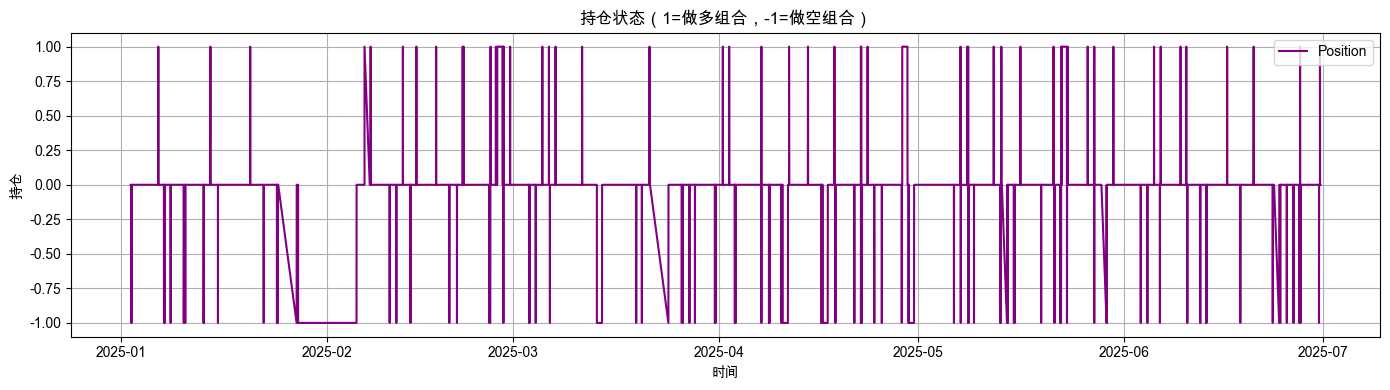

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['datetime'], df['position'], label="Position", color='purple')
plt.title("持仓状态（1=做多组合，-1=做空组合）")
plt.xlabel("时间")
plt.ylabel("持仓")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

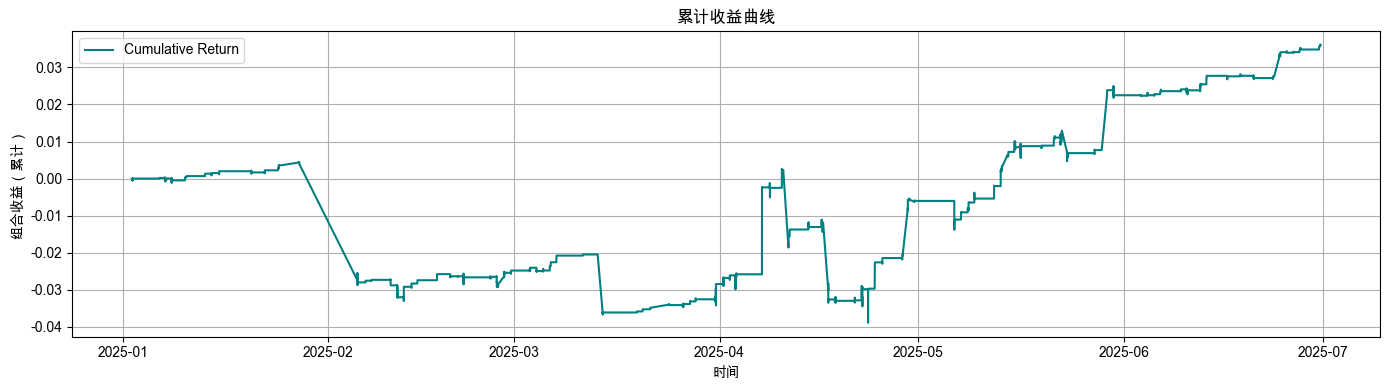

In [ ]:
df['cum_ret'] = (1 + df['combo_ret']).cumprod()
df['cum_ret'] = df['cum_ret'] / df['cum_ret'].iloc[WIN] - 1

plt.figure(figsize=(14,4))
plt.plot(df['datetime'], df['cum_ret'], label="Cumulative Return", color='teal')
plt.title("累计收益曲线")
plt.xlabel("时间")
plt.ylabel("组合收益（累计）")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from pairs_kalman_updated import combine_md_datetime,load_and_prepare,merge_and_aggregate,kalman_and_cointegration

etf_path = "../data/518880.SH_20250101_20250630.csv"
TD_path = "../data/AU(T+D).SGE_20250101_20250630.csv"

etf_df = load_and_prepare(etf_path, prefix='ETF')
TD_df = load_and_prepare(TD_path, prefix='TD')



ImportError: cannot import name 'combine_md_datetime' from 'pairs_kalman_updated' (/Users/guziyi/Desktop/htsc/gold_pairstrading/code/pairs_kalman_updated.py)

/Users/guziyi/Desktop/htsc/gold_pairstrading/code/pairs_kalman_updated.py:148: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_static = model.params[1]


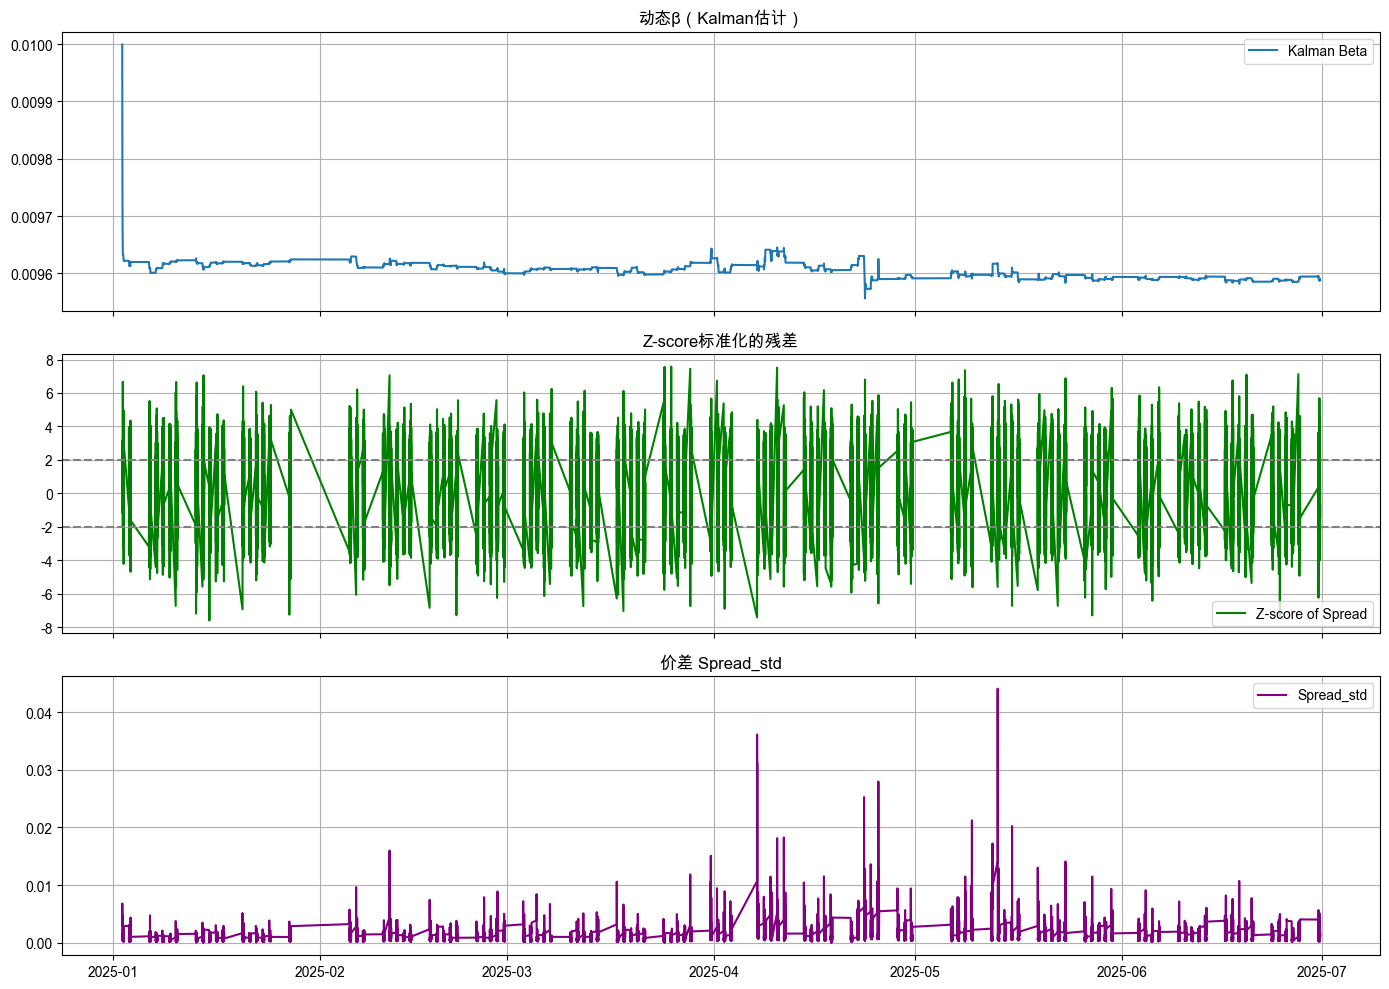

(                  DateTime  ETF_Price  TD_Price  beta_kalman    spread  \
 0      2025-01-02 09:25:04     5.9755   621.310     0.009999 -0.237218   
 1      2025-01-02 09:25:07     5.9755   621.285     0.009999 -0.236586   
 2      2025-01-02 09:25:10     5.9755   621.280     0.009998 -0.236155   
 3      2025-01-02 09:25:16     5.9755   621.200     0.009998 -0.234977   
 4      2025-01-02 09:25:22     5.9755   621.080     0.009997 -0.233401   
 ...                    ...        ...       ...          ...       ...   
 522856 2025-06-30 15:29:19     7.3135   764.075     0.009588 -0.012382   
 522857 2025-06-30 15:29:31     7.3135   764.150     0.009588 -0.013083   
 522858 2025-06-30 15:29:37     7.3135   764.150     0.009588 -0.013066   
 522859 2025-06-30 15:29:52     7.3135   764.150     0.009588 -0.013049   
 522860 2025-06-30 15:29:55     7.3135   764.085     0.009588 -0.012410   
 
           zscore  
 0            NaN  
 1            NaN  
 2            NaN  
 3            NaN 

In [ ]:
from pairs_kalman_updated import prepare_and_align_generic,load_and_prepare,kalman_and_cointegration
df_etf = load_and_prepare("../data/518880.SH_20250101_20250630.csv", prefix="ETF")
df_td = load_and_prepare("../data/AU(T+D).SGE_20250101_20250630.csv", prefix="TD")
merged_agg = prepare_and_align_generic(df_etf, df_td,
                                       price_col1='ETF_Price', price_col2='TD_Price',
                                       prefix1='ETF', prefix2='TD', time_col='DateTime')

kalman_and_cointegration(merged_agg, win=60,early_stop=True)

In [ ]:
#pairs_kalman_updated
#库函数
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

def combine_md_datetime(df, date_col='MDDate', time_col='MDTime', new_col='DateTime', drop_original=True):
    """
    时间标准化，因为输入的时间是两列，
    通用型的时候可以增加datetime鉴别
    """
    df[date_col] = df[date_col].astype(str)
    df[time_col] = df[time_col].astype(str).str.zfill(9)
    datetime_str = df[date_col] + ' ' + df[time_col].str[:6]
    df[new_col] = pd.to_datetime(datetime_str, format='%Y%m%d %H%M%S')
    if drop_original:
        df.drop(columns=[date_col, time_col], inplace=True)
    return df

def load_and_prepare(filepath, prefix):
    """
    加载数据，清洗数据，加前缀
    """
    df = pd.read_csv(filepath, usecols=['MDDate', 'MDTime', 'LastPx', 'Buy1Price', 'Sell1Price'])
    df = df[df['LastPx'] != 0]
    df = df.dropna(subset=['Buy1Price', 'Sell1Price']).copy()
    df['MidPrice'] = (df['Buy1Price'] + df['Sell1Price']) / 2
    df = combine_md_datetime(df)
    
    df.rename(columns={
        'MidPrice': f'{prefix}_Price',
        'Buy1Price': f'{prefix}_Buy1Price',
        'Sell1Price': f'{prefix}_Sell1Price'
    }, inplace=True)
    
    df.drop(columns=['LastPx'], inplace=True)
    
    return df


def merge_and_aggregate(df1, df2, group_size=30):
    """
    合并聚合生成merged
    """
    merged = pd.merge_asof(df1,df2,on='DateTime', direction='backward')
    
    merged['group'] = merged.index // group_size
    merged_agg = merged.groupby('group').tail(1).reset_index(drop=True)
    merged_agg.drop(columns=['group'], inplace=True)
    
    return merged_agg

#Kalman参数
OBS_VAR = 0.01
STATE_VAR = 0.0001
INIT_MEAN = 1.0
INIT_VAR = 1.0

@njit
def kalman_filter_numba(py, px, obs_var, state_var, init_mean, init_var):
    n = len(py)
    betas = np.zeros(n)
    spreads = np.zeros(n)

    state_mean = init_mean
    state_var_ = init_var

    for i in range(n):
        pred_mean = state_mean
        pred_var = state_var_ + state_var
        k_gain = pred_var / (pred_var * px[i]**2 + obs_var)
        state_mean = pred_mean + k_gain * (py[i] - pred_mean * px[i])
        state_var_ = (1 - k_gain * px[i]) * pred_var

        betas[i] = state_mean
        spreads[i] = py[i] - state_mean * px[i]

    return betas, spreads

def kalman_and_cointegration(df, win=60,early_stop=True):
    """
    Kalman滤波，协整检验
    这个window可以调整，因为最后准备做一个通用型的，
    所以考虑之后加一个鉴别数据频率的函数，根据函数生成所需要的窗口大小
    """
    #识别价格列
    price_cols = [col for col in df.columns if col != 'DateTime' and pd.api.types.is_numeric_dtype(df[col])]
    if len(price_cols) < 2:
        raise ValueError("找不到两个价格列，至少需要两列价格")

    col_y, col_x = price_cols[:2]
    
    #静态协整检验
    """
    先协整检验，然后动态估计beta，
    """
    X = sm.add_constant(df[col_x])
    model = sm.OLS(df[col_y], X).fit()
    beta_static = model.params[1]
    residuals = model.resid
    adf_stat, p_value, _, _, crit_vals, _ = adfuller(residuals)

    test_result = {
        'price_y': col_y,
        'price_x': col_x,
        '静态beta': beta_static,
        'ADF统计量': adf_stat,
        'p值': p_value,
        '5%临界值': crit_vals['5%'],
        '是否协整(5%)': p_value < 0.05
    }
    
    # 不协整就终止
    if early_stop and p_value >= 0.05:
        print(f"不协整，p值={p_value:.4f} ≥ 0.05")
        return None, test_result

    #Kalman估计beta（for循环）
    """
    这里用numba优化了一下，准备看看跑的情况
    """
    py = df[col_y].values.astype(np.float64)
    px = df[col_x].values.astype(np.float64)

    betas, spreads = kalman_filter_numba(
        py, px, OBS_VAR, STATE_VAR, INIT_MEAN, INIT_VAR
    )

    df['beta_kalman'] = betas
    df['spread'] = spreads
    df['spread_mean'] = df['spread'].rolling(window=win).mean()
    df['spread_std'] = df['spread'].rolling(window=win).std()
    std = df['spread_std'].copy()
    std = np.clip(std, 1e-4, np.inf)
    df['zscore'] = (df['spread'] - df['spread_mean']) / std

    #画图看看
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    axes[0].plot(df['DateTime'], df['beta_kalman'], label='Kalman Beta')
    axes[0].set_title("动态β（Kalman估计）")
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(df['DateTime'], df['zscore'], label='Z-score of Spread', color='green')
    axes[1].axhline(2, linestyle='--', color='gray')
    axes[1].axhline(-2, linestyle='--', color='gray')
    axes[1].set_title("Z-score标准化的残差")
    axes[1].legend()
    axes[1].grid()

    axes[2].plot(df['DateTime'], df['spread_std'], label='Spread_std', color='purple')
    axes[2].set_title("价差 Spread_std")
    axes[2].legend()
    axes[2].grid()
    
    plt.tight_layout()
    plt.show()
    
    return df[['DateTime', col_y, col_x, 'beta_kalman', 'spread', 'zscore']], test_result


In [ ]:
def resample_price(df, price_col='MidPrice', interval='30s'):
    """
    通用型重采样函数：按指定价格列重采样为 interval 频率，取均值
    """
    df = df[['DateTime', price_col]].copy().set_index('DateTime')
    return df.resample(interval).mean().dropna().reset_index()

def infer_frequency(df, sample_size=1000):
    """
    快速推断频率（单位：秒），仅使用前 sample_size 条记录
    """
    dt_sorted = df['DateTime'].sort_values().iloc[:sample_size + 1]
    diffs = dt_sorted.diff().dropna().dt.total_seconds()
    return diffs.median()

def prepare_and_align_generic(df1, df2,
                               price_col1='MidPrice', price_col2='MidPrice',
                               prefix1='A', prefix2='B',
                               interval='30s', direction=None):
    """
    通用型配对交易数据准备函数：
    - 对两个不同频率的数据分别按 interval 聚合
    - 自动判断频率高低，选择低频数据作为主时间轴
    - 支持灵活方向设置（默认低频为主，高频对齐）
    - 输出标准化格式 ['DateTime', A_Price, B_Price]
    """
    df1_rs = resample_price(df1.copy(), price_col1, interval)
    df2_rs = resample_price(df2.copy(), price_col2, interval)

    freq1 = infer_frequency(df1_rs)
    freq2 = infer_frequency(df2_rs)

    if freq1 >= freq2:
        base, base_col, base_prefix = df1_rs, price_col1, prefix1
        target, target_col, target_prefix = df2_rs, price_col2, prefix2
    else:
        base, base_col, base_prefix = df2_rs, price_col2, prefix2
        target, target_col, target_prefix = df1_rs, price_col1, prefix1

    if direction is None:
        direction = 'backward'

    target_aligned = pd.merge_asof(
        base[['DateTime']], target.sort_values('DateTime'),
        on='DateTime', direction=direction
    )

    merged_agg = pd.concat([
        base.set_index('DateTime'),
        target_aligned.set_index('DateTime')[[target_col]]
    ], axis=1)

    merged_agg.columns = [f'{base_prefix}_Price', f'{target_prefix}_Price']
    merged_agg = merged_agg.dropna().reset_index()
    merged_agg.rename(columns={'index': 'DateTime'}, inplace=True)

    return merged_agg


/Users/guziyi/Desktop/htsc/gold_pairstrading/code/pairs_kalman_updated.py:148: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_static = model.params[1]


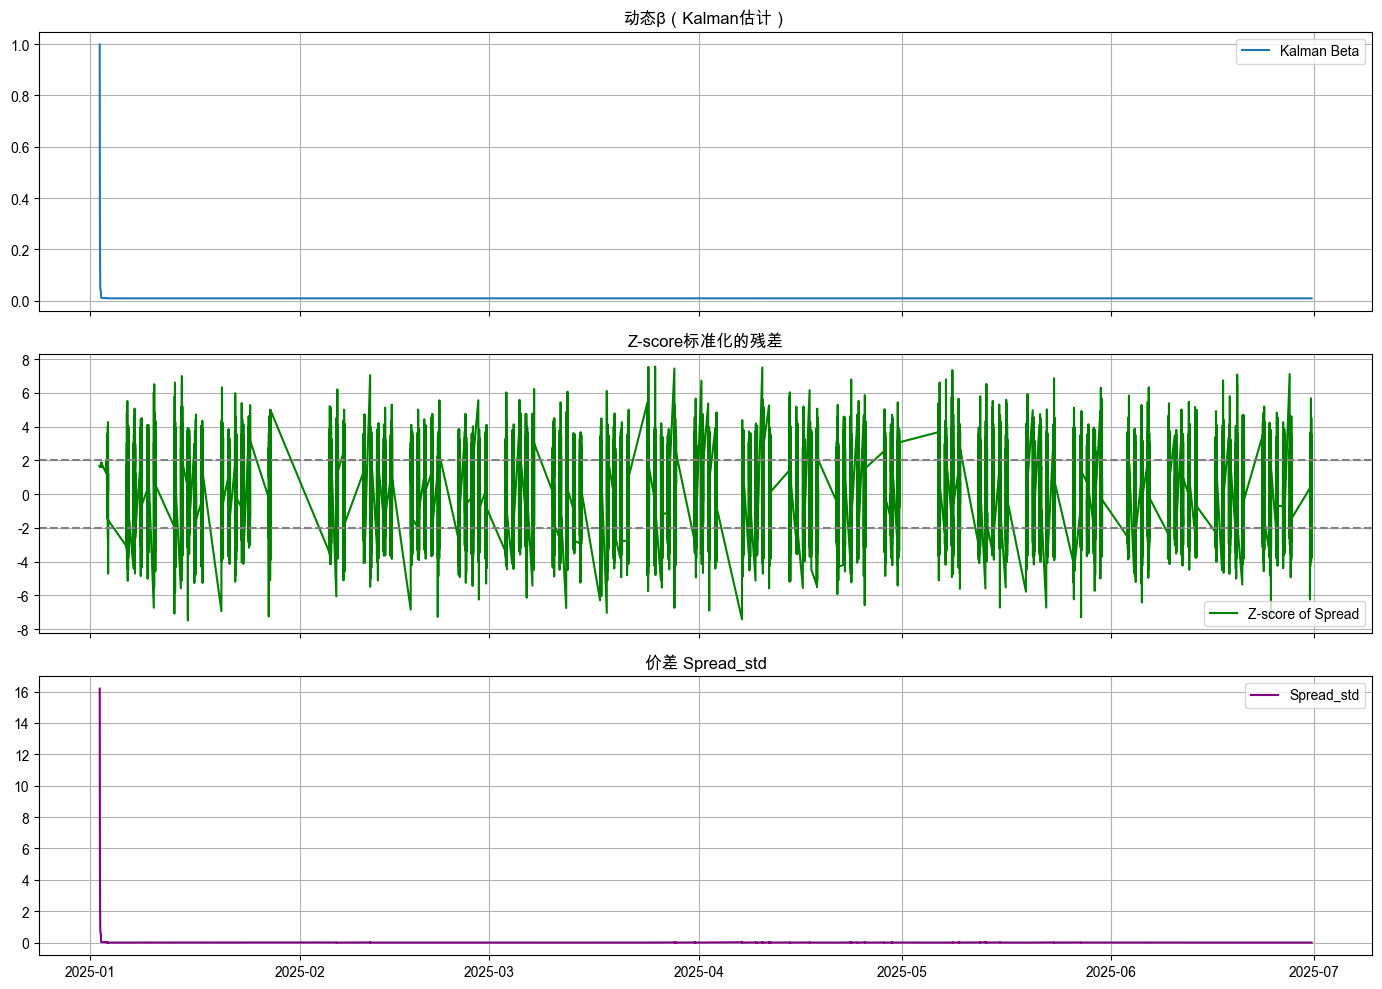

{'price_y': 'ETF_Price', 'price_x': 'TD_Price', '静态beta': np.float64(0.0095060948613688), 'ADF统计量': np.float64(-15.691571660451999), 'p值': np.float64(1.4317123497801556e-28), '5%临界值': np.float64(-2.8615455289494767), '是否协整(5%)': np.True_}


In [ ]:
from pairs_kalman_updated import load_and_prepare, prepare_and_align_generic, kalman_and_cointegration

# === Step 1: 加载数据（替换为你的真实路径） ===
etf_df = load_and_prepare("../data/518880.SH_20250101_20250630.csv", prefix="ETF")
td_df = load_and_prepare("../data/AU(T+D).SGE_20250101_20250630.csv", prefix="TD")

# === Step 2: 对齐时间，自动识别高低频 ===
merged_df = prepare_and_align_generic(etf_df, td_df,
                                      price_col1="ETF_Price",
                                      price_col2="TD_Price",
                                      prefix1="ETF", prefix2="TD")

# === Step 3: Kalman估计 + 协整检验 + zscore计算 + 可视化 ===
result_df, coint_test = kalman_and_cointegration(merged_df)

# 可选查看协整结果
print(coint_test)

In [ ]:
#updated
#库函数
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

#合并时间
def combine_md_datetime(df, date_col='MDDate', time_col='MDTime', new_col='DateTime', drop_original=True):
    """
    时间标准化，因为输入的时间是两列，
    通用型的时候可以增加datetime鉴别
    """
    df[date_col] = df[date_col].astype(str)
    df[time_col] = df[time_col].astype(str).str.zfill(9)
    datetime_str = df[date_col] + ' ' + df[time_col].str[:6]
    df[new_col] = pd.to_datetime(datetime_str, format='%Y%m%d %H%M%S')
    if drop_original:
        df.drop(columns=[date_col, time_col], inplace=True)
    return df

def load_and_prepare(filepath, prefix):
    """
    加载数据，清洗数据，加前缀
    """
    df = pd.read_csv(filepath, usecols=['MDDate', 'MDTime', 'LastPx', 'Buy1Price', 'Sell1Price'])
    df = df[df['LastPx'] != 0]
    df = df.dropna(subset=['Buy1Price', 'Sell1Price']).copy()
    df['MidPrice'] = (df['Buy1Price'] + df['Sell1Price']) / 2
    df = combine_md_datetime(df)
    
    df.rename(columns={
        'MidPrice': f'{prefix}_Price',
        'Buy1Price': f'{prefix}_Buy1Price',
        'Sell1Price': f'{prefix}_Sell1Price'
    }, inplace=True)
    
    df.drop(columns=['LastPx'], inplace=True)
    
    return df

def infer_frequency(df, sample_size=1000):
    """
    快速推断频率（单位：秒），仅使用前 sample_size 条记录
    """
    dt_sorted = df['DateTime'].sort_values().iloc[:sample_size + 1]
    diffs = dt_sorted.diff().dropna().dt.total_seconds()
    return diffs.median()

def prepare_and_align_generic(df1, df2,
                               price_col1='MidPrice', price_col2='MidPrice',
                               prefix1='A', prefix2='B',
                               time_col='DateTime'):
    """
    通用型配对交易数据准备函数（无重采样版）：
    - 自动识别高低频数据
    - 高频数据保留每个时间的第一行
    - 高频数据只保留低频数据时间点的记录
    - 返回标准格式 ['DateTime', A_Price, B_Price']
    """

    # 确保时间列格式一致
    df1[time_col] = pd.to_datetime(df1[time_col])
    df2[time_col] = pd.to_datetime(df2[time_col])

    # 推断频率
    freq1 = infer_frequency(df1)
    freq2 = infer_frequency(df2)

    # 判定高低频
    if freq1 >= freq2:
        low_df, low_col, low_prefix = df1, price_col1, prefix1
        high_df, high_col, high_prefix = df2, price_col2, prefix2
    else:
        low_df, low_col, low_prefix = df2, price_col2, prefix2
        high_df, high_col, high_prefix = df1, price_col1, prefix1

    # 高频数据保留每个时间第一行
    high_df = high_df.groupby(time_col, as_index=False).first()

    # 高频数据只保留低频数据的时间点
    high_df = high_df[high_df[time_col].isin(low_df[time_col])]

    # 合并两个数据
    merged = pd.merge(low_df[[time_col, low_col]],
                      high_df[[time_col, high_col]],
                      on=time_col, how='inner')

    # 重命名为标准列
    merged.rename(columns={
        low_col: f'{low_prefix}_Price',
        high_col: f'{high_prefix}_Price'
    }, inplace=True)

    return merged[[time_col, f'{low_prefix}_Price', f'{high_prefix}_Price']]

#Kalman参数
OBS_VAR = 0.01
STATE_VAR = 0.0001
INIT_MEAN = 0.01
INIT_VAR = 1.0

@njit
def kalman_filter_numba(py, px, obs_var, state_var, init_mean, init_var):
    n = len(py)
    betas = np.zeros(n)
    spreads = np.zeros(n)

    state_mean = init_mean
    state_var_ = init_var

    for i in range(n):
        pred_mean = state_mean
        pred_var = state_var_ + state_var
        k_gain = pred_var / (pred_var * px[i]**2 + obs_var)
        state_mean = pred_mean + k_gain * (py[i] - pred_mean * px[i])
        state_var_ = (1 - k_gain * px[i]) * pred_var

        betas[i] = state_mean
        spreads[i] = py[i] - state_mean * px[i]

    return betas, spreads

def kalman_and_cointegration(df, win=60,early_stop=True):
    """
    Kalman滤波，协整检验
    这个window可以调整，因为最后准备做一个通用型的，
    所以考虑之后加一个鉴别数据频率的函数，根据函数生成所需要的窗口大小
    """
    #识别价格列
    price_cols = [col for col in df.columns if col != 'DateTime' and pd.api.types.is_numeric_dtype(df[col])]
    if len(price_cols) < 2:
        raise ValueError("找不到两个价格列，至少需要两列价格")

    col_y, col_x = price_cols[:2]
    
    #静态协整检验
    """
    先协整检验，然后动态估计beta，
    """
    X = sm.add_constant(df[col_x])
    model = sm.OLS(df[col_y], X).fit()
    beta_static = model.params[1]
    residuals = model.resid
    adf_stat, p_value, _, _, crit_vals, _ = adfuller(residuals)

    test_result = {
        'price_y': col_y,
        'price_x': col_x,
        '静态beta': beta_static,
        'ADF统计量': adf_stat,
        'p值': p_value,
        '5%临界值': crit_vals['5%'],
        '是否协整(5%)': p_value < 0.05
    }
    
    # 不协整就终止
    if early_stop and p_value >= 0.05:
        print(f"不协整，p值={p_value:.4f} ≥ 0.05")
        return None, test_result

    #Kalman估计beta（for循环）
    """
    这里用numba优化了一下，准备看看跑的情况
    """
    py = df[col_y].values.astype(np.float64)
    px = df[col_x].values.astype(np.float64)

    betas, spreads = kalman_filter_numba(
        py, px, OBS_VAR, STATE_VAR, INIT_MEAN, INIT_VAR
    )

    df['beta_kalman'] = betas
    df['spread'] = spreads
    df['spread_mean'] = df['spread'].rolling(window=win).mean()
    df['spread_std'] = df['spread'].rolling(window=win).std()
    std = df['spread_std'].copy()
    std = np.clip(std, 1e-4, np.inf)
    df['zscore'] = (df['spread'] - df['spread_mean']) / std

    #画图看看
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    axes[0].plot(df['DateTime'], df['beta_kalman'], label='Kalman Beta')
    axes[0].set_title("动态β（Kalman估计）")
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(df['DateTime'], df['zscore'], label='Z-score of Spread', color='green')
    axes[1].axhline(2, linestyle='--', color='gray')
    axes[1].axhline(-2, linestyle='--', color='gray')
    axes[1].set_title("Z-score标准化的残差")
    axes[1].legend()
    axes[1].grid()

    axes[2].plot(df['DateTime'], df['spread_std'], label='Spread_std', color='purple')
    axes[2].set_title("价差 Spread_std")
    axes[2].legend()
    axes[2].grid()
    
    plt.tight_layout()
    plt.show()
    
    return df[['DateTime', col_y, col_x, 'beta_kalman', 'spread', 'zscore']], test_result
